In [12]:
# pylint: disable=line-too-long,useless-suppression
# ------------------------------------
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.
# ------------------------------------

"""
DESCRIPTION:
    This sample demonstrates how to use agent operations with code interpreter from
    the Azure Agents service using a synchronous client.

USAGE:
    python sample_agents_code_interpreter.py

    Before running the sample:

    pip install azure-ai-projects azure-ai-agents azure-identity

    Set these environment variables with your own values:
    1) PROJECT_ENDPOINT - The Azure AI Project endpoint, as found in the Overview
                          page of your Azure AI Foundry portal.
    2) MODEL_DEPLOYMENT_NAME - The deployment name of the AI model, as found under the "Name" column in
       the "Models + endpoints" tab in your Azure AI Foundry project.
"""

import os
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import CodeInterpreterTool
from azure.ai.agents.models import FilePurpose, MessageRole
from azure.identity import DefaultAzureCredential
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
AIFOUNDRY_AGENT_PROJECT_NAME = os.getenv("AIFOUNDRY_AGENT_PROJECT_NAME")
AIFOUNDRY_AGENT_MODEL_DEPLOYMENT_NAME = os.getenv("AIFOUNDRY_AGENT_MODEL_DEPLOYMENT_NAME")

asset_file_path = os.path.abspath(
    os.path.join(os.getcwd(), "./assets/synthetic_500_quarterly_results.csv")
)

project_client = AIProjectClient(
    endpoint=AIFOUNDRY_AGENT_PROJECT_NAME,
    credential=DefaultAzureCredential(),
)

with project_client:
    agents_client = project_client.agents

    # Upload a file and wait for it to be processed
    # [START upload_file_and_create_agent_with_code_interpreter]
    file = agents_client.files.upload_and_poll(file_path=asset_file_path, purpose=FilePurpose.AGENTS)
    print(f"Uploaded file, file ID: {file.id}")

    code_interpreter = CodeInterpreterTool(file_ids=[file.id])

    # Create agent with code interpreter tool and tools_resources
    agent = agents_client.create_agent(
        model=AIFOUNDRY_AGENT_MODEL_DEPLOYMENT_NAME,
        name="my-agent",
        instructions="You are helpful agent",
        tools=code_interpreter.definitions,
        tool_resources=code_interpreter.resources,
    )
    # [END upload_file_and_create_agent_with_code_interpreter]
    print(f"Created agent, agent ID: {agent.id}")

    thread = agents_client.threads.create()
    print(f"Created thread, thread ID: {thread.id}")

    # Create a message
    message = agents_client.messages.create(
        thread_id=thread.id,
        role="user",
        content="Could you please create bar chart in TRANSPORTATION sector for the operating profit from the uploaded csv file and provide file to me?",
    )
    print(f"Created message, message ID: {message.id}")

    run = agents_client.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)
    print(f"Run finished with status: {run.status}")

    if run.status == "failed":
        # Check if you got "Rate limit is exceeded.", then you want to get more quota
        print(f"Run failed: {run.last_error}")

    agents_client.files.delete(file.id)
    print("Deleted file")

    # [START get_messages_and_save_files]
    messages = agents_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    target_dir = f"{Path.cwd()}\\output\\"
    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            agents_client.files.save(file_id=file_id, file_name=file_name, target_dir=target_dir)
            print(f"Saved image file to: {target_dir} / {file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
    # [END get_messages_and_save_files]

    last_msg = agents_client.messages.get_last_message_text_by_role(thread_id=thread.id, role=MessageRole.AGENT)
    if last_msg:
        print(f"Last Message: {last_msg.text.value}")

    agents_client.delete_agent(agent.id)
    print("Deleted agent")

Uploaded file, file ID: assistant-6TL2RDZDbpJB8bfD4bQAWr
Created agent, agent ID: asst_Cl4pxpBdaHbzADCcb9cQ9113
Created thread, thread ID: thread_TaDZNAVdfQiyoa95awyg2UUT
Created message, message ID: msg_qwnI9sLPFlWnjyMEzrFRM1g0
Run finished with status: completed
Deleted file
Messages: <iterator object azure.core.paging.ItemPaged at 0x1e2f411a710>
Saved image file to: c:\Users\dschlesinger\code\ongoing\genai-agents\Azure AI Agents\1-Agent with code interpreter\output\ / assistant-RbPTF7F9vkmS9x3um7weGJ_image_file.png
File Paths:
  Type: file_path
  Text: sandbox:/mnt/data/transportation_operating_profit.png
  File ID: assistant-UK3qH9VwyAp3aTSntvd1hK
  Start Index: 189
  End Index: 242
Last Message: The bar chart for operating profit in the TRANSPORTATION sector has been created. You can download the chart using the link below:

[Download the transportation operating profit bar chart](sandbox:/mnt/data/transportation_operating_profit.png)
Deleted agent


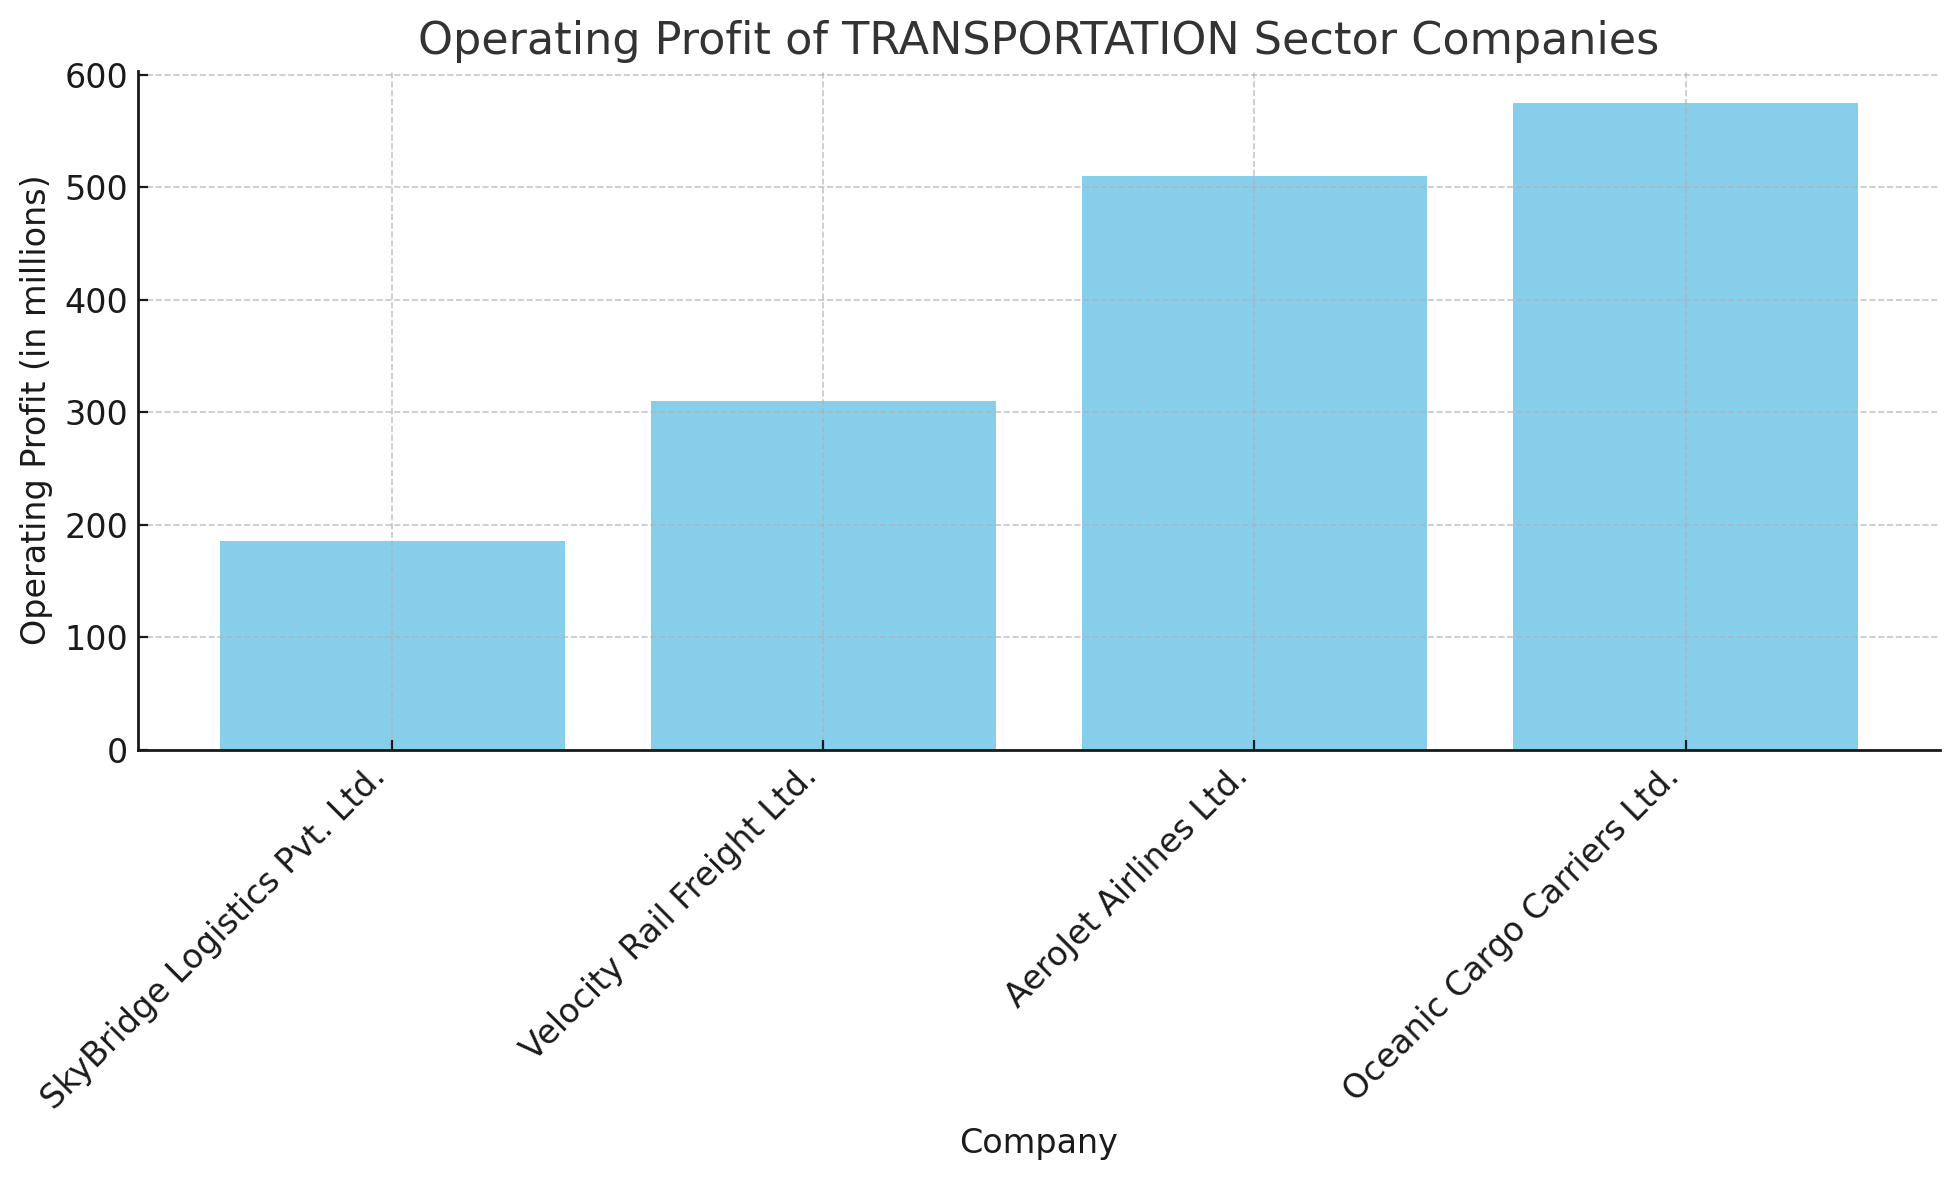

In [13]:
from IPython.display import display, HTML, JSON, Markdown, Image

display(Image(target_dir+file_name))

In [14]:
agents_client.delete_agent(agent.id)
print("Deleted agent")

ValueError: HTTP transport has already been closed. You may check if you're calling a function outside of the `with` of your client creation, or if you called `close()` on your client already.